<a href="https://colab.research.google.com/github/tonyscan6003/CE6003/blob/master/Etivity_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity 2: Deep Convolutional Neural Network on CIFAR-10 Dataset

In this assignment, we will gain some practical experience of coding a deep convolutional neural network in Tensorflow. The simplest way to code a network is to use the High level Keras API within Tensorflow 2.5.  

## (a) Introduction

 In this assignment to reduce training time and computation, we will train our network using the simple [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
![link text](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

The goal of this Etivity is to build and train your own Deep Convolutional Neural Network. This notebook contains standard keras/Tensorflow code to perform data processing, training set up and testing metrics, as outlined in the steps below. This will allow you to focus on developing the architecture & code for your network. 

1. Load Dataset - We will import the CIFAR-10 Dataset using the Tensorflow Data Set API.
2. Prepare Data - We will slightly modify the dataset before it is sent to the model for training.
3. Model Coding - We will write code to build the model using the Tensorflow keras API.
  * **You will code your neural network model in this section**
4. Compile Model - We will complile the model and verify that it has been correctly constructed.
5. Train Model - We will train the model using the imported dataset.
6. Test Model - We test the model on the training data and obtain a classification report and confusion matrix.

The principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials. Tutorials on [image classification](https://www.tensorflow.org/tutorials/images/classification) and [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) are useful for this Etivity.  


## (b) Notes on Architecture selection & development

A key task in this Etivity is selecting an appropriate architecture. You can base your archicture on any of the types seen in the lecture notes or published literature. It is however recommended to ensure you can get a standard CNN type architecture to successfully train before attempting a more complex architecture or adding further enhancements to your network to improve performance.
   Many published networks are designed to work with larger sized input images (e.g. 224 x 224). Often large (e.g. 7 x 7) convolution kernels and pooling layers are first applied to the input image, which agressively reduce the spatial dimensions of the network. As the CIFAR-10 dataset only has 32 x 32 images, it is recommended that just an intial 3 x 3 convolution is applied to the input image (as shown in the figure below), which will preserve the spatial dimensions of the input, before any other layers are added. It is expected that as you add more layers to the network the spatial dimensions will reduce and there will also be a corresponding increase the number of channels of the output feature map. The architecture will end with a [global average pooling layer](https://arxiv.org/pdf/1312.4400.pdf) and a fully-connected layer (called a *dense* layer in Keras/Tensorflow) with softmax activation which gives us our 10 class predictions. A skeleton code has been provided for any general architure using this structure in section 3.
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/Architecture_outline.jpg?raw=true)


#House Keeping

In [1]:
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Add,
    MaxPool2D,
    GlobalAveragePooling2D,
    AveragePooling2D,
    Input,
    Flatten,
    Conv1D,
    Dense,
    Conv2D,
    BatchNormalization,
    Activation,
)
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

import mlflow.tensorflow
import numpy as np

print("TensorFlow version", tf.__version__)
print("Keras version", keras.__version__)

mlflow.tensorflow.autolog()
%load_ext lab_black

TensorFlow version 2.5.0
Keras version 2.5.0


To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU. 

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

# 1. Load Dataset

In this assignment, we will be using the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.htmlhttps://). CIFAR-10 is often used as a "Hello World" dataset that is often used to ensure a network architecture is working before moving on to training with more complex datasets.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (airplane, automobile, **bird**, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

We will use the [Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) API to download the CIFAR10 dataset.

In [3]:
# We initally load the raw training/validation/test dataset
import tensorflow_datasets as tfds

ds, info = tfds.load("cifar10", with_info=True)

raw_train = tfds.load("cifar10", split="train[0%:90%]")
raw_val = tfds.load("cifar10", split="train[91%:100%]")
raw_test = tfds.load("cifar10", split="test")

# 2. Prepare Data

After importing raw datasets using tfds load, we create an input pipeline that processes & batches this data before it is supplied to the model for training using the virtual machine GPU.

In [4]:
# Labels corresponding to categories
label_str = (
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [5]:
def data_pipe(image, label):
    # Cast and normalize the image to [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # TODO: This isn't really normalization... also it dims the image
    image = image  # - 0.5
    label = tf.cast(label, tf.float32)
    return image, label


def prepare_dataset(dataset, batch_size):
    """Splits a dataset into features and labels, apply preprocessing steps and batch."""
    # src_dataset = src_dataset.shuffle(num_train_examples)
    prep_dataset = dataset.map(lambda x: (x["image"], x["label"]))
    prep_dataset = prep_dataset.map(data_pipe)
    prep_dataset = prep_dataset.batch(batch_size)
    return prep_dataset


def generate_datasets(train, validation, test, batch_size=32):
    train_dataset = prepare_dataset(train, batch_size)
    val_dataset = prepare_dataset(validation, batch_size)
    test_dataset = prepare_dataset(test, batch_size)
    return train_dataset, val_dataset, test_dataset


train_dataset, val_dataset, test_dataset = generate_datasets(
    raw_train, raw_val, raw_test
)

Plot some examples of the training dataset.

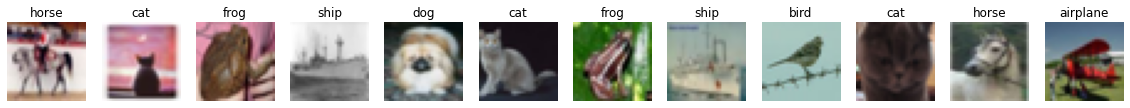

In [6]:
n_plots = 12  # number of plots
fig, axes = plt.subplots(1, n_plots, figsize=(20, 10))

for idx, (img, label) in enumerate(train_dataset.take(n_plots).as_numpy_iterator()):
    # Only take a single example
    axes[idx].imshow(img[0])  # Take the first example of the batch
    axes[idx].axis("off")
    axes[idx].set_title(
        label_str[int(label[0])]
    )  # Label of the first example in the batch

# 3. Model Coding

In this section You may develop your own model architecture to perform image recognition with the CIFAR-10 Dataset.

There are some recommendations and helper code in this section that you may choose use, or you can also use your own approach to creating your architecture. 

Please Leave a note at the end of the notebook explaining your approach/results for the e-moderator.





 
## Note 1: Keras Function/Sequential API

Within Keras there are two API's for coding network models: Sequential and functional. You may have already used the [seqential model](https://https://www.tensorflow.org/guide/keras/sequential_model) to code basic artifical neural networks. The [functional model](https://www.tensorflow.org/guide/keras/functional) is more general and enables us to include feedforward paths which are required to code more advanced networks such as ResNet or DenseNet. The functional API has been used to code the helper functions repeating unit/top level skeleton detailed below.

## Note 2: Repeating Unit

In many Deep architectures there will often be a repeating unit(s) that is composed of a sequence of layers, for example Conv,ReLU & Batch Normalisation. Specific layers can be turned on or off as required. This also allows experimentation of the entire architecture with/without specific layers (e.g. Batch Normalisation)  You may wish to create other combinations of layers or additional repeating units depending on your architecture.

In the code cell below we can see an example of a `repeat_unit` function where the number of kernel filters and kernel size is specified. Batch Normalisation and activation layers can be turned on/off as required.

 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 
 * Batch Normalization layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) 
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) 
 

In [7]:
# Example of a Basic Repeating unit
def repeat_unit(
    inputs,
    num_channels=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=False,
):
    """
    inputs: Input to repeat unit.
    num_channels: number of channels in convolution layer of repeat unit, nominally = 16
    kernel_size: number of kernels to use in convolution, nominally = 3
    strides: number of strides for kernel, nominally = 1
    activation: type of activation applied to output of convolution, nominally ReLU.
    x = output of repeat_unit
    """
    conv = Conv2D(
        num_channels,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
    )
    x = conv(inputs)

    if activation is not None:
        x = Activation(activation)(x)

    if batch_normalization:
        x = BatchNormalization()(x)

    return x

In [8]:
class ResidualUnit(keras.layers.Layer):
    def __init__(
        self,
        n_layers=2,
        batch_norm=True,
        filters=32,
        kernel_size=3,
        strides=2,
        reduce_stride=True,
        padding="same",
        kernel_initializer="he_normal",
        activation=relu,
    ):
        super(ResidualUnit, self).__init__()
        self.n_layers = n_layers
        self.batch_norm = batch_norm
        self.reduce_stride = reduce_stride
        self.initial_stride = strides
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.activation = activation

        self.conv_layers = []
        # Regular path, just convolutions, batch norm
        for n in range(self.n_layers):
            # Reduce stride for layers other than the first, so we don't shrink the image too much
            if n >= 1 and self.reduce_stride:
                self.strides = 1

            self.conv_layers.append(
                Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    padding=self.padding,
                    kernel_initializer=self.kernel_initializer,
                )
            )
            if self.batch_norm:
                self.conv_layers.append(BatchNormalization())
            # Add activation for all layers but the last
            if n != self.n_layers:
                self.conv_layers.append(activation)

        # Skip connection
        self.skip_conn = Conv2D(
            filters=self.filters,
            kernel_size=(1, 1),
            strides=self.initial_stride,
            padding=self.padding,
            kernel_initializer=self.kernel_initializer,
        )

    def get_config(self):
        return super().get_config()

    def call(self, inputs):

        x = inputs
        input_shape = inputs.shape

        for layer in self.conv_layers:
            x = layer(x)

        skip_x = self.skip_conn(inputs)

        # assert (
        #     x.shape == skip_x.shape
        # ), f"Skip_x {skip_x.shape} and x {x.shape} do not have the same shape"

        x = Add()([x, skip_x])
        x = self.activation(x)
        return x

## Note 3: Top Level

In the code cell below, an incomplete skeleton function is provided for your top level.  
* This uses the Keras functional API
* A single repeating unit which does not reduce the spatial dimensions of the input is placed at the top of the stack. You can change the number of channels/kernel size to suit your own architecture.
* You can add your own layers/repeating units etc to build your own architecture with the function.
* At the end of the stack we add a [global average pooling layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and fully connected [(Dense)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation. (Alternatively to the Global Average pooling Dense layers can be used, this approach uses more parameter (memory) and is commonly seen in earlier Deeep Learning architectures such as AlexNet)

In [9]:
def resnet_model(input_shape, name="", num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    # Define input of model
    inputs = Input(shape=input_shape)
    x = BatchNormalization()(inputs)

    # Add First repeating Unit
    x = repeat_unit(x, 16, batch_normalization=True)
    x = MaxPool2D(strides=2)(x)
    x = ResidualUnit(filters=32, n_layers=3, strides=1)(x)
    x = ResidualUnit(filters=32, n_layers=3)(x)
    x = ResidualUnit(filters=64, n_layers=3)(x)
    x = MaxPool2D(strides=2)(x)
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax", kernel_initializer="he_normal")(
        x
    )

    # Model definition
    model = Model(name=name, inputs=inputs, outputs=outputs)
    return model

In [11]:
def cnn_model(input_shape, name="", num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    # Define input of model
    inputs = Input(shape=input_shape)

    # Add First repeating Unit
    x = repeat_unit(inputs, 64)
    x = BatchNormalization()(x)
    x = MaxPool2D(strides=2)(x)
    x = repeat_unit(x, 128, batch_normalization=True)
    x = repeat_unit(x, 128, batch_normalization=True)
    x = MaxPool2D(strides=2)(x)
    x = repeat_unit(x, 256, batch_normalization=True)
    x = repeat_unit(x, 256, batch_normalization=True)
    # x = MaxPool2D(strides=2)(x)
    x = GlobalAveragePooling2D()(x)
    # x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax", kernel_initializer="he_normal")(
        x
    )

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We define  loss function, the optimizer and metrics. 

Note the use here of [Sparse Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). This loss function allows us to input integer values for true classes. With the regular categorical cross entropy loss function the supplied labels must be frist converted to a one-hot representation,  but this special loss function allows us to avoid manually converting to the one-hot representation.


# 5. Model Training

Before getting to the actual training, let's search for the best learning rate parameter for our model. This was inspired by the following blog:

[https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)




In [99]:
class ExponentialScheduler(keras.callbacks.Callback):
    def __init__(self, steps=7):
        super(ExponentialScheduler, self).__init__()
        self.steps = steps
        self.schedule = self.get_exponential_scheduler(steps)
        self.name = "ExponentialScheduler"

    def get_exponential_scheduler(self, steps):
        """Wrapper function to generate a customized exponential learning rate schedule

        Parameters
        ----------
        steps : int, Optional
            The number steps at which the learning rate will decrease by a factor of 10.

        Returns
        -------
        exponential_schedule : function
            Initialized exponential schedule with pre-defined number of steps

        """

        def exponential_schedule(epoch, lr):
            """Exponential schedule that reduced the learning rate by a factor of ten after 'steps' epochs"""
            return lr * (0.1 ** (epoch / steps))

        return exponential_schedule

    def on_epoch_begin(self, epoch, logs=None):
        current_lr = float(K.get_value(self.model.optimizer.learning_rate))
        new_lr = self.schedule(epoch, current_lr)
        K.set_value(self.model.optimizer.lr, new_lr)
        # print(f"Epoch {epoch:03d}: Learning rate is {new_lr:6.4f}")


class ExponentialSchedulerLRSearcher(ExponentialScheduler):
    """Children class used solely for the purpose of finding the optimal learning rate of a model.
    It implements a on_batch_end method that updates the optimizer learning rate by multiplying it
    by a factor.
    """

    def __init__(self, factor, *args, **kwargs):
        super(ExponentialSchedulerLRSearcher, self).__init__(*args, **kwargs)
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        """At the end of each batch, we update the learning rate."""
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(
            self.model.optimizer.learning_rate,
            self.model.optimizer.learning_rate * self.factor,
        )

In [47]:
def get_num_params(model):
    """Helper function to calculate the number of parameters in a model"""
    trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    non_trainable_params = np.sum(
        [np.prod(v.get_shape()) for v in model.non_trainable_weights]
    )
    total = trainable_params + non_trainable_params

    return trainable_params, non_trainable_params, total

In [74]:
def find_optimal_lr(
    model, train_dataset, min_lr, max_lr, batch_size=32, epochs=1, lr_steps=7
):
    init_weights = model.get_weights()
    iters_per_epoch = len(train_dataset) * epochs
    factor = np.exp(np.log(max_lr / min_lr) / iters_per_epoch)

    init_lr = K.get_value(model.optimizer.learning_rate)
    exp_schedule = ExponentialSchedulerLRSearcher(steps=lr_steps, factor=factor)

    history = model.fit(train_dataset, epochs=epochs, callbacks=[exp_schedule])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_schedule.rates, exp_schedule.losses


def plot_lr_vs_loss(rates, losses):
    plt.figure(figsize=(12, 6))
    plt.plot(rates, losses)
    plt.title("Plot of learning rate vs loss")
    plt.gca().set_xscale("log")
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [112]:
input_shape = (32, 32, 3)
batch_size = 64
init_lr = 1e-5
lr_steps = 15

train_dataset, val_dataset, test_datset = generate_datasets(
    raw_train, raw_val, raw_test, batch_size
)

# model = network_top(input_shape=input_shape, name=name)
model = cnn_model(input_shape=input_shape)
model.compile(
    loss="SparseCategoricalCrossentropy",
    optimizer=Nadam(learning_rate=init_lr),
    metrics=["accuracy"],
)

In [113]:
rates, losses = find_optimal_lr(
    model, train_dataset, min_lr=1e-5, max_lr=10, lr_steps=lr_steps
)

2021/11/17 20:40:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '86723059026948f889643b2e28ed67e9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


  6/704 [..............................] - ETA: 4:40 - loss: 2.3818 - accuracy: 0.0938 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.3234s). Check your callbacks.


704/704 [==============================] - 23s 29ms/step - loss: 2.8608 - accuracy: 0.2532
INFO:tensorflow:Assets written to: C:\Users\gamin\AppData\Local\Temp\tmpqztcpffj\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\gamin\AppData\Local\Temp\tmpqztcpffj\model\data\model\assets


Batch size: 256
lr_steps: 15


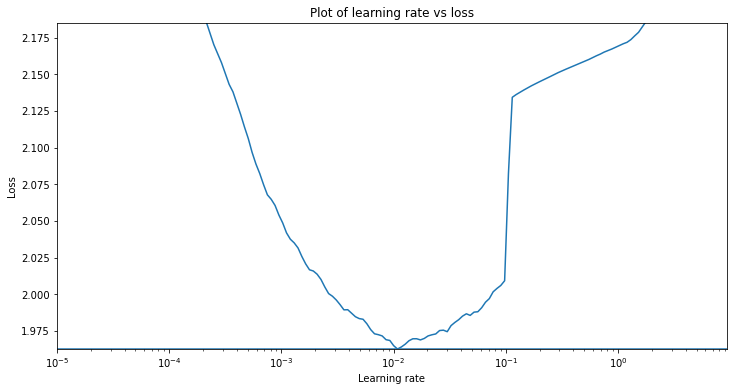

In [ ]:
print(f"Batch size: {batch_size}")
print(f"lr_steps: {lr_steps}")

plot_lr_vs_loss(rates, losses)

With the batch size 32 and lr_steps 15 a value between $10^{-3}$ and $5\times 10^{-3}$ is a good candidate for maximum learning rate. We will use this to define a [1Cycle training policy](https://sgugger.github.io/the-1cycle-policy.html).

Code below adapted from from [Aurelien Geron](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb)

Other values tested:
- `batch_size=64`, `lr_steps=15` -> $[10^{-3}, 2\times 10^{-3}]$
- `batch_size=128`, `lr_steps=15` -> $[10^{-3}, 2\times 10^{-3}]$
- `batch_size=256`, `lr_steps=15` -> $[10^{-3}, 5\times 10^{-3}]$

In [98]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(
        self,
        iterations,
        max_rate,
        start_rate=None,
        last_iterations=None,
        last_rate=None,
    ):
        """

        Parameters
        ----------
        iterations : int
            The total number of iterations per batch multiplied by the number of epochs
        max_rate : float
            The maximum learning rate
        start_rate : float, Optional
        last_iterations : float, Optional
        last_rate : float, Optional
        """
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        self.name = "one_cycle_scheduler"

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return (rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1

    def on_batch_begin(self, batch, logs=None):
        # First part, learning rate increases until we reach the mid point
        if self.iteration < self.half_iteration:
            rate = self._interpolate(
                0, self.half_iteration, self.start_rate, self.max_rate
            )
        # Next the learning rate decreases for the same number of iterations
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(
                self.half_iteration,
                2 * self.half_iteration,
                self.max_rate,
                self.last_rate,
            )
        # Finally drop the learning rate drastically
        else:
            rate = self._interpolate(
                2 * self.half_iteration,
                self.iterations,
                self.start_rate,
                self.last_rate,
            )
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [100]:
with mlflow.start_run():
    input_shape = (32, 32, 3)
    batch_size = 32
    epochs = 20
    init_lr = 1e-3
    lr_steps = 15
    name = f"medium_cnn_exponential_lr_global_avg_top"

    mlflow.log_param("init_lr", init_lr)
    mlflow.log_param("lr_steps", lr_steps)
    mlflow.log_param("model_name", name)

    train_dataset, val_dataset, test_datset = generate_datasets(
        raw_train, raw_val, raw_test, batch_size
    )
    # model = network_top(input_shape=input_shape, name=name)
    model = cnn_model(input_shape=input_shape, name=name)
    model.compile(
        loss="SparseCategoricalCrossentropy",
        optimizer=Nadam(learning_rate=init_lr),
        metrics=["accuracy"],
    )

    iterations = len(train_dataset) * epochs
    max_rate = 5e-3
    callbacks = [
        # keras.callbacks.EarlyStopping(patience=5),
        # ExponentialScheduler(steps=lr_steps),
        OneCycleScheduler(iterations, max_rate=max_rate),
    ]

    mlflow.log_param("scheduler", callbacks[-1].name)

    trainable, non_trainable, total = get_num_params(model)
    mlflow.log_param("trainable_params", trainable)
    mlflow.log_param("non_trainable_params", non_trainable)
    mlflow.log_param("total_params", total)

    model.summary()
    with tf.device("GPU:0"):
        history = model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=val_dataset,
            callbacks=callbacks,
            batch_size=batch_size,
        )

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_45 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_46 (Activation)   (None, 16, 16, 128)       0   

1407/1407 [==============================] - 43s 30ms/step - loss: 1.2047 - accuracy: 0.5680 - val_loss: 1.1858 - val_accuracy: 0.5756
Epoch 2/20
1407/1407 [==============================] - 38s 27ms/step - loss: 0.8071 - accuracy: 0.7196 - val_loss: 1.7833 - val_accuracy: 0.4789
Epoch 3/20
1407/1407 [==============================] - 39s 27ms/step - loss: 0.6535 - accuracy: 0.7746 - val_loss: 1.3227 - val_accuracy: 0.5731
Epoch 4/20
1407/1407 [==============================] - 39s 27ms/step - loss: 0.5574 - accuracy: 0.8093 - val_loss: 1.0772 - val_accuracy: 0.6667
Epoch 5/20
1407/1407 [==============================] - 39s 27ms/step - loss: 0.4924 - accuracy: 0.8316 - val_loss: 1.1431 - val_accuracy: 0.6540
Epoch 6/20
1407/1407 [==============================] - 39s 27ms/step - loss: 0.4428 - accuracy: 0.8494 - val_loss: 1.1328 - val_accuracy: 0.6633
Epoch 7/20
1407/1407 [==============================] - 38s 27ms/step - loss: 0.4070 - accuracy: 0.8617 - val_loss: 0.8871 - val_accura

INFO:tensorflow:Assets written to: C:\Users\gamin\AppData\Local\Temp\tmpx_ddkuu4\model\data\model\assets


We will plot the loss and accuracy for the training and validation data sets.

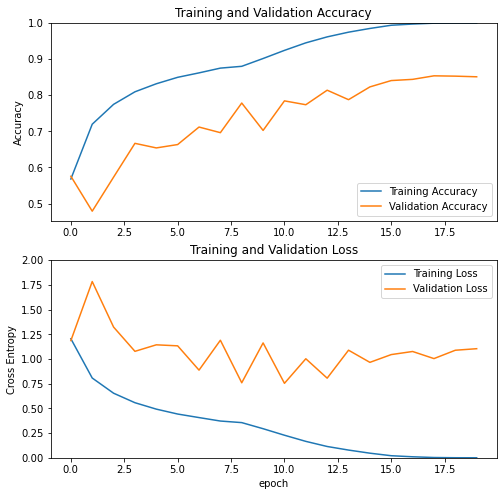

In [101]:
# print(history.history.keys())
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 2.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

# 6. Model Testing
We will iterate through the test data and analyse the results using tools from sklearn. We create a classification report, a confusion matrix and also plot a few examples from the test set.

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

In [102]:
n_test = 100  # number of batches to use
store_predictions = []
store_labels = []
for image_batch, label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions, axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions, (1, n_test * batch_size)))
y_true = np.squeeze(np.reshape(store_labels, (1, n_test * batch_size)))

Create and plot a confusion matrix.

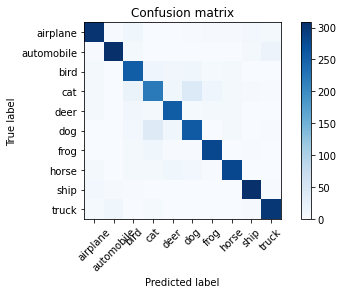

In [103]:
# https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(cm, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


plot_confusion_matrix(cm)

Generate & print the classification report

In [104]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.89      0.90      0.89       337
  automobile       0.95      0.91      0.93       338
        bird       0.79      0.83      0.81       306
         cat       0.73      0.68      0.70       323
        deer       0.84      0.86      0.85       297
         dog       0.78      0.79      0.79       325
        frog       0.90      0.91      0.91       307
       horse       0.90      0.88      0.89       317
        ship       0.93      0.94      0.94       326
       truck       0.91      0.92      0.91       324

    accuracy                           0.86      3200
   macro avg       0.86      0.86      0.86      3200
weighted avg       0.86      0.86      0.86      3200



Plot some test images and predicted labels.

(32, 10)
(32,)
Predictions:
 [7 0 6 9 5 1 7 0 5 7 7 2 7 9 2 8 8 8 7 9 4 2 3 5 0 8 2 8 1 8 6 0]


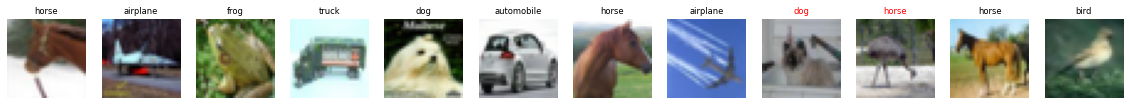

In [105]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions, axis=1)
print(np.shape(predictions))
print("Predictions:\n", predictions.numpy())


i = 0
n_plots = 12  # number of plots
f, axarr = plt.subplots(1, n_plots, figsize=(20, 10))

for image in image_batch[0:n_plots, :, :, :]:  # Only take a single example
    axarr[i].imshow(image[:, :, :])
    axarr[i].axis("off")

    color = "black" if predictions[i] == int(label_batch[i]) else "red"
    axarr[i].set_title(label_str[int(predictions[i])], fontsize="small", color=color)
    i = i + 1

# Please Leave a note here explaining your approach/results for the e-moderator.

